<a href="https://colab.research.google.com/github/nunoisaac/Machine-Learning-Kaggle-Competition/blob/main/Nuno_Isaac_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##What's Cooking
Our task was to determine the cuisine of a recipe given the ingredients. There are 20 possible cuisines, and the data was given in the form of id, cuisine, and a list of recipe ingredents. Challenges: deciding how to preprocess the data, differentiating between cuisines that use very similar ingredients.

https://www.kaggle.com/c/whats-cooking/overview

In [ ]:
# Import the libraries we'll use below.
import os
import csv
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import plotly.graph_objs as plotly  # for interactive plots
from matplotlib.patches import Wedge

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from google.colab import files
from sklearn.model_selection import train_test_split

In [ ]:
!pip install keras-tuner -q

In [ ]:
!pip install -Uqq ipdb
import ipdb
# for adding debugger breakpoints:
# ipdb.set_trace()

# debugger commands:
# https://docs.python.org/3/library/pdb.html#debugger-commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle competitions download -c whats-cooking

  0% 0.00/1.76M [00:00<?, ?B/s]
100% 1.76M/1.76M [00:00<00:00, 45.8MB/s]
  0% 0.00/426k [00:00<?, ?B/s]
100% 426k/426k [00:00<00:00, 134MB/s]
  0% 0.00/25.8k [00:00<?, ?B/s]
100% 25.8k/25.8k [00:00<00:00, 25.0MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  test.json.zip
  inflating: test.json               
   creating: __MACOSX/
  inflating: __MACOSX/._test.json    

Archive:  train.json.zip
  inflating: train.json              
  inflating: __MACOSX/._train.json   

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

3 archives were successfully processed.


#Load the data:

In [ ]:
data_file = open('/content/train.json','r')
data = data_file.read()
#parse
df = json.loads(data)
d = pd.json_normalize(df)

print(df[1])
print(d.shape)
d.head()


{'id': 25693, 'cuisine': 'southern_us', 'ingredients': ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']}
(39774, 3)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


#Data Preprocessing
We will remove measurements, non alphabetical characters, and make the input data case insensitive.

In [ ]:
import re

def preprocess_df(df):
  def process_recipe(recipe):
    for i, x in enumerate(recipe):
      # remove measurements
      x = list(map(lambda x: re.sub(r'\(.*oz.\)','', x), x))
      # remove non alphabet characters
      x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))
      x = "".join(x)                                  
      x = x.lower()
      recipe[i] = x
    return recipe
  
  df['ingredients'] = df['ingredients'].apply(process_recipe)
  
  return df

d = preprocess_df(d)

#Split the data into train and validation sets:

In [ ]:
#Train and validation split
X_train, X_val, Y_train, Y_val = train_test_split(d['ingredients'],d['cuisine'], test_size = .2, random_state=42)
print(X_train.shape)
print(X_val.shape)

print(X_train[0])

(31819,)
(7955,)
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']


#Baseline
Italian is the most common cuisine in our dataset so we'll predict italian for every recipe as our baseline, to be a starting point for comparison.

In [ ]:
#Set baseline to the most common cuisine
def get_counts(cuisine):
  counts = {}
  for cuisine in cuisine:
    if cuisine not in counts:
      counts[cuisine] = 0
    counts[cuisine] += 1

  #returns number of times a particular cuisine appears in the set
  return counts

#number of times a particular cuisine appears in the training set
train_counts = get_counts(Y_train)
#Returns the cuisine with the highest count
cuisine = max(train_counts, key = train_counts.get)
#Returns max count
max_count = max(train_counts.values())
print(f'Baseline for train set: {cuisine} : {max_count} Accuracy: {max_count / len(Y_train)}')

#number of times a particular cuisine appears in the test set
val_counts = get_counts(Y_val)
cuisine = max(val_counts, key = val_counts.get)
max_count = max(val_counts.values())
print(f'Baseline for test set: {cuisine} : {max_count} Accuracy: {max_count / len(Y_val)}\n')

Baseline for train set: italian : 6271 Accuracy: 0.19708350356705112
Baseline for test set: italian : 1567 Accuracy: 0.19698302954116909



#Prepare Kaggle submission:

In [ ]:
#Create CSV file for Kaggle with predictions for test data
test_file = open('/content/test.json','r')
test_data = test_file.read()
#parse
test_data = json.loads(test_data)
test_df = pd.json_normalize(test_data)

#Since our baseline is all Italian, we simply predict Italian for every example 
#and submit our predictions to Kaggle
pred = {'id':[test_df['id'][i] for i in range(len(test_df))], 
        'cuisine':['italian' for i in range(len(test_df))]}

pred_df = pd.DataFrame(pred)
pred_df.to_csv('test_predictions_baseline.csv', index=False, header=True, columns=["id","cuisine"])

#Kaggle Submission Results#
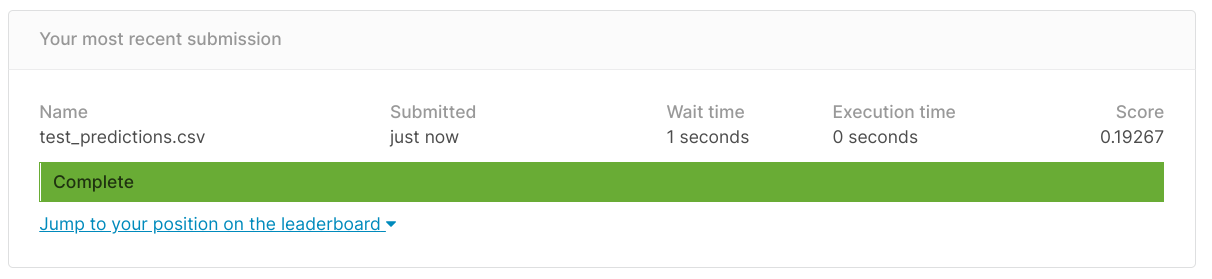

# Data Analysis & Feature Selection


###Average recipe length per cuisine:

Longest recipe: 65 ingredients


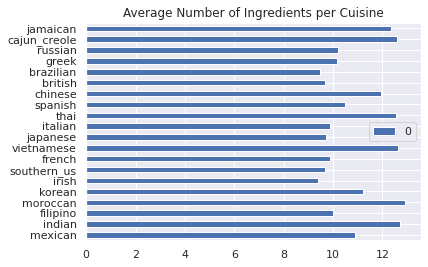

In [ ]:
avg_recipe_lengths = {}
max_length = 0

Y_train = np.array(Y_train)
X_train = np.array(X_train)

for i, recipe in enumerate(X_train):
  if Y_train[i] not in avg_recipe_lengths:
    avg_recipe_lengths[Y_train[i]] = 0
  
  max_length = max(max_length, len(recipe))
  avg_recipe_lengths[Y_train[i]] += len(recipe)


for k, v in avg_recipe_lengths.items():
  avg_recipe_lengths[k] = v / train_counts[k]


temp = pd.DataFrame.from_dict(avg_recipe_lengths, orient='index')
temp.plot.barh(title='Average Number of Ingredients per Cuisine')

print(f"Longest recipe: {max_length} ingredients")

### List of most common ingredients per cuisine:

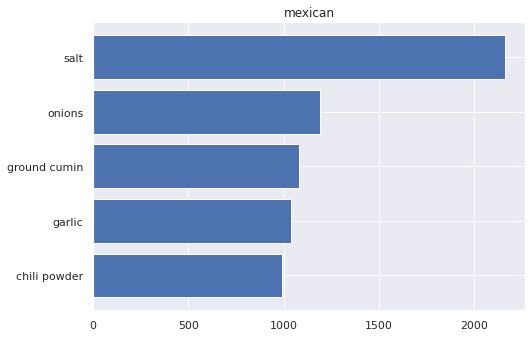

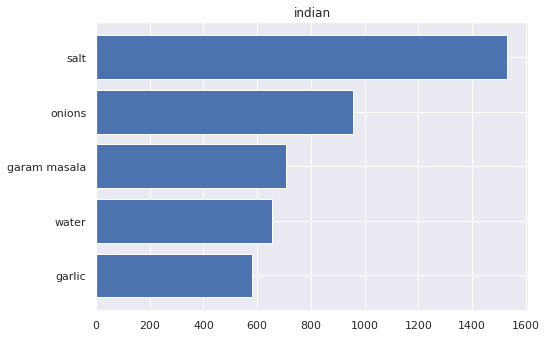

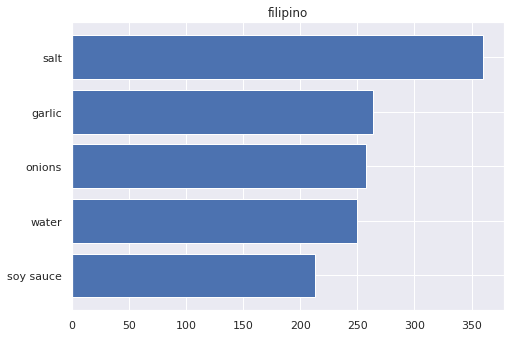

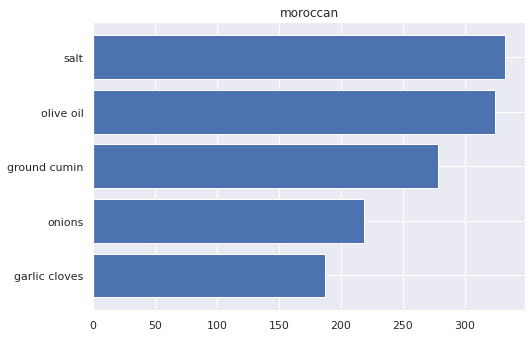

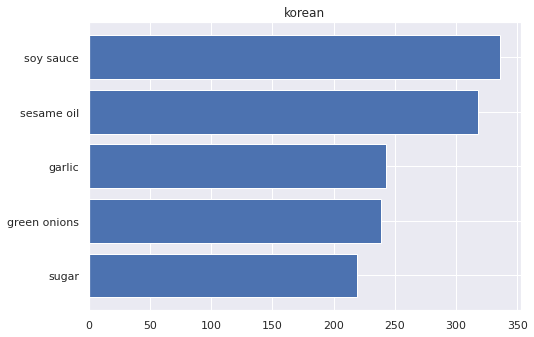

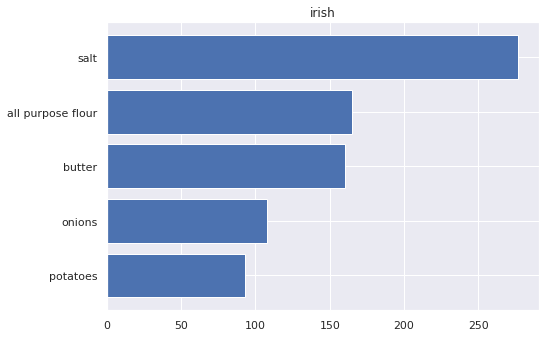

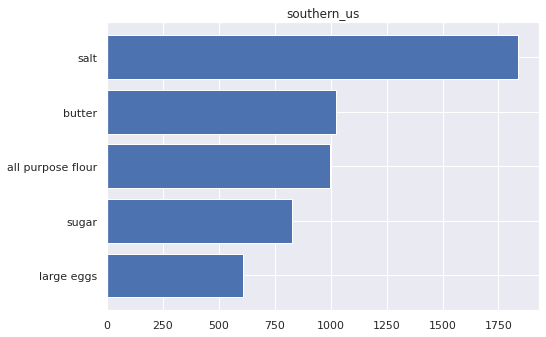

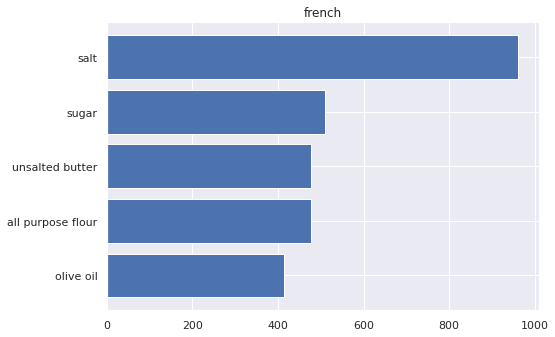

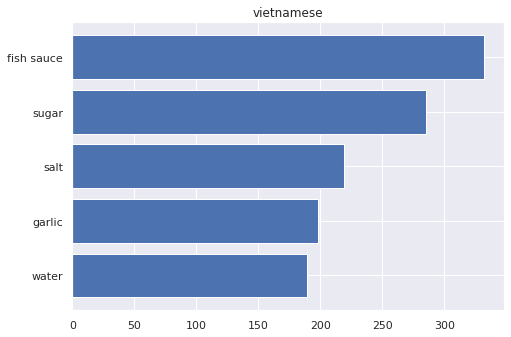

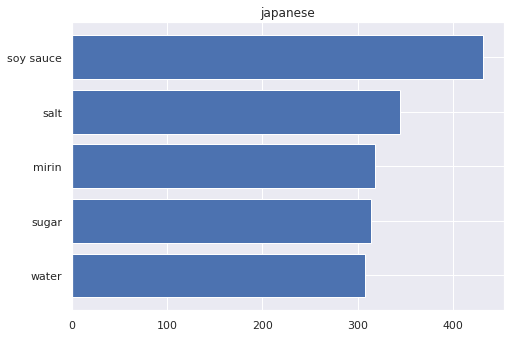

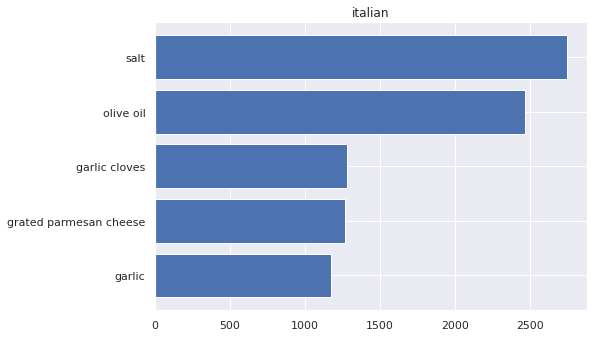

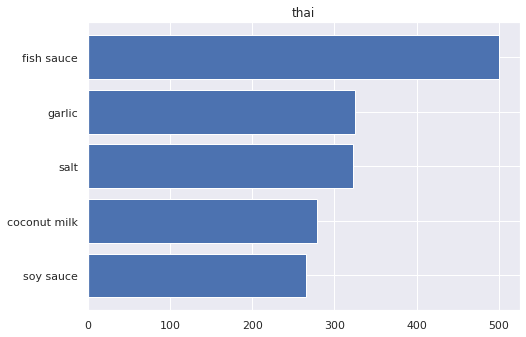

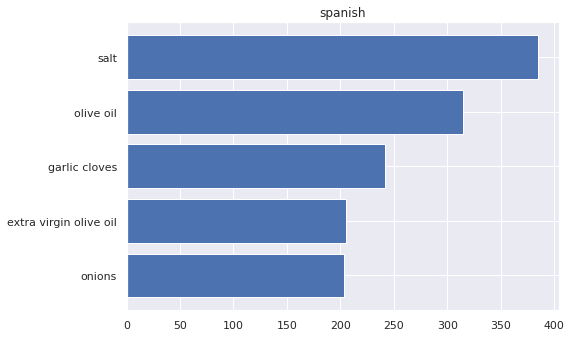

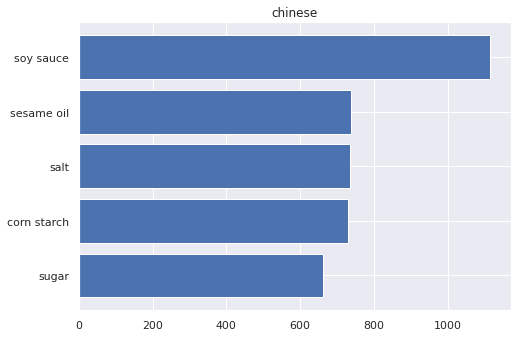

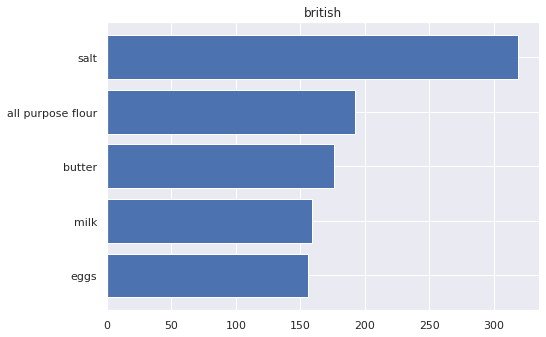

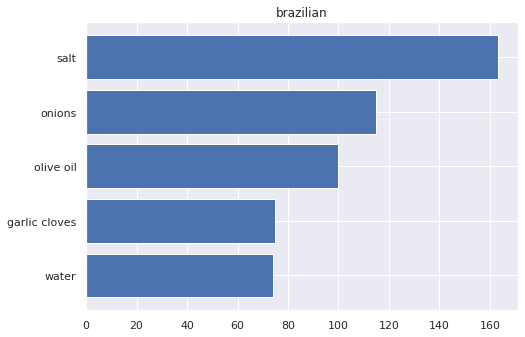

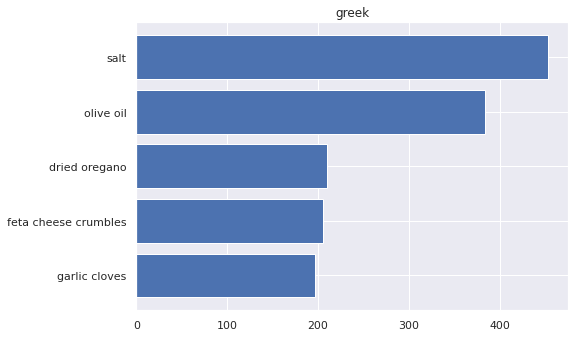

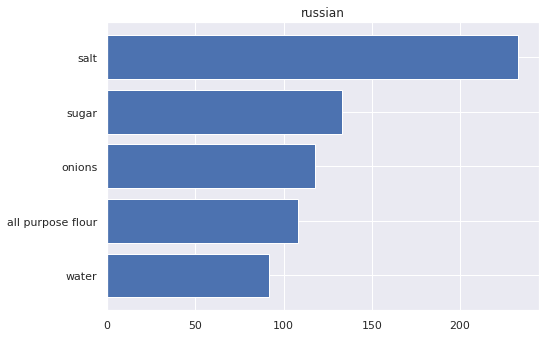

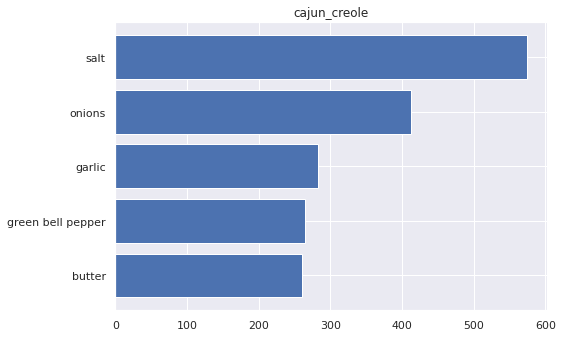

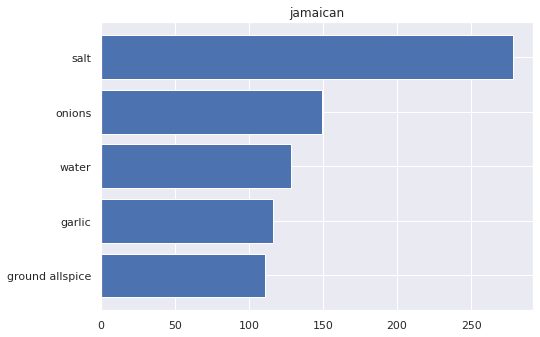

In [ ]:
#Holds a list of cuisines with a count of the number of times a particular 
#ingredient is used for one of its recipie
common_ingredients = {}

def count_vocab(X_train):
  vocab_count={}
  for i, lst in enumerate(X_train):
    if Y_train[i] not in common_ingredients:
      common_ingredients[Y_train[i]] = {}
    for ingredient in lst:
      #Count ingredients
      if ingredient not in common_ingredients[Y_train[i]]:
        common_ingredients[Y_train[i]][ingredient] = 0
      common_ingredients[Y_train[i]][ingredient] += 1
      if ingredient not in vocab_count:
        vocab_count[ingredient] = 0
      vocab_count[ingredient] += 1
  return vocab_count

vocab_count=count_vocab(X_train)

#Plot top five ingredients per cuisine 
for cuisine in common_ingredients:
  sorted_d = dict(sorted(common_ingredients[cuisine].items(),
                         key=lambda items: items[1], reverse=True))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ingredients = list(sorted_d.keys())[:5]
  counts = list(sorted_d.values())[:5]
  ax.invert_yaxis()
  ax.set_title(cuisine)
  ax.barh(ingredients, counts)
  plt.show()

###Remove ingredients in the dataset that may cause issues
As part of our attempts to avoid overfitting we remove ingredients that appear only once, duplicate ingredients, and salt because it's in almost every recipe.

In [ ]:
print(dict(sorted(vocab_count.items(),key=lambda items: items[1], reverse=False)))

for lst in X_train:
  dupes = set()
  for i,ingredient in enumerate(lst):
    if ingredient not in dupes:
      dupes.add(ingredient)
    else:
      lst.pop(i)
      
    if vocab_count[ingredient] == 1:
      lst.pop(i)
    if ingredient == 'salt':
      lst.pop(i)

vocab_count = count_vocab(X_train)
print(dict(sorted(vocab_count.items(),key=lambda items: items[1], reverse=False)))

{'country crock honey spread': 1, 'lavender honey': 1, 'sashimi grade tuna': 1, 'smoked almonds': 1, 'ikura': 1, 'dulong': 1, 'pink lentil': 1, 'whole wheat cereal': 1, 'manischewitz potato starch': 1, 'manischewitz matzo meal': 1, 'blacan': 1, 'orchid': 1, 'hillshire farms low fat sausage': 1, 'unhulled sesame seeds': 1, 'brioche bread': 1, 'heinz ketchup': 1, 'shredded american cheese': 1, 'gluten free vanilla extract': 1, 'refrigerated chocolate chip cookie dough': 1, 'ciabatta loaf': 1, 'shiraz': 1, 'kosher wine': 1, 'chicharron': 1, 'margarine spread': 1, 'dark ale': 1, 'irish red ale': 1, 'aged manchego cheese': 1, 'toasted buns': 1, 'bordelaise sauce': 1, 'pumpkin seed oil': 1, 'chioggia': 1, 'avocado dressing': 1, 'waffle fries': 1, 'butter cake': 1, 'kasu': 1, 'standing rib roast': 1, 'vegan yogurt': 1, 'candied bacon': 1, 'german mustard': 1, 'bigoli': 1, 'asian sweet chili sauce': 1, 'praline syrup': 1, 'bagel chips': 1, 'jamaican jerk': 1, 'medium potatoes': 1, 'cross rib r

### List of ingredients that are unique to a particular cuisine:

In [ ]:
ingredients = {}
for i, recipe in enumerate(X_train):
  for ingredient in recipe:
    if Y_train[i] not in ingredients:
      ingredients[Y_train[i]] = set()
    
    ingredients[Y_train[i]].add(ingredient)

ingredient_count = {}
for cuisine, v in ingredients.items():
  for ingredient in v:
    if ingredient not in ingredient_count:
      ingredient_count[ingredient] = [cuisine, 0]
    ingredient_count[ingredient][1] += 1

unique = dict.fromkeys(ingredients.keys())
for k, v in ingredient_count.items():
  if v[1] == 1:
    #ipdb.set_trace()
    if unique[v[0]] == None:
      unique[v[0]] = set()
    unique[v[0]].add(k)

for cuisine in unique.items():
  print(cuisine)

('mexican', {'refried black beans', 'knorr garlic minicub', 'mulato chiles', 'chunky mild salsa', 'silver tequila', 'pumpkinseed kernels', 'frozen tater tots', 'achiote', 'guacamole', 'nopalitos', 'knorr chicken flavor bouillon', 'green chile sauce', 'goya sazon', 'knorr  fiesta sides    mexican rice', 'chihuahua cheese', 'crema mexicana', 'mexicorn', 'sazon seasoning', 'achiote paste', 'bbq seasoning', 'prepared guacamole', 'campbell s condensed cream of chicken soup', 'old el paso  thick  n chunky salsa', 'piloncillo', 'doritos', 'mexican beer', '    less sodium taco seasoning mix', 'canned jalapeno peppers', 'green enchilada sauce', 'chipotle', 'knorr rice side   cheddar broccoli', 'taco sauce', 'anasazi beans', 'ibarra chocolate', 'knorr tomato bouillon with chicken flavor cube', 'old el paso  chopped green chiles', 'fajita size flour tortillas', 'enchilada sauce', 'mexican seasoning mix', 'queso fresca', 'sweet yellow corn', 'sofrito', 'knorr reduc sodium chicken flavor bouillon',

# Feature Representation

### Prepping data by mapping words to integers
Since we can't use strings to make calculations, here we create a dictionary that will help us convert the ingredients from a list of strings to a "sparse list" where each ingredient is represented by its index. In addition, we'll create a reverse index that converts the sparse list back to a list of strings.

In [ ]:
# create a single set of all ingredients
flat_ingredients = {x for v in ingredients.values() for x in v}

# mapping words to integers
index = {k: v+3 for v, k in enumerate(flat_ingredients)}
#index for sparse representation of labels
index_label = {label: v for v, label in enumerate(ingredients.keys())}

reverse_index = {(k+3): v for k, v in enumerate(flat_ingredients)}
reverse_index_label = {v:label  for v, label in enumerate(ingredients.keys())}

index[0] = '<UNUSED>'  # start of input
index[1] = '#'        # out-of-vocabulary (OOV)
index[2] = '<UNUSED>'
reverse_index[0] = '<UNUSED>'
reverse_index[1] = '#'
reverse_index[2] = '<UNUSED>'

print(f"number of ingredients: {len(flat_ingredients)} index size: {len(index)}")

number of ingredients: 4669 index size: 4672


Function to convert Ingredient lists and labels into sparse representations

In [ ]:
#Converts list of ingredients into sparse representation
def sparse_recipie(recipie):
  sparse_lst = [index.get(ingredient, 2) for ingredient in recipie]
  return sparse_lst
#Converts list of labels into sparse representation
def sparse_labels(labels):
  sparse_lst = [index_label.get(cuisine) for cuisine in labels]
  return sparse_lst

def decode_ingredients(recipie):
  decoded_lst = [reverse_index.get(x) for x in recipie]
  return decoded_lst

def decode_labels(preds):
  return np.array([reverse_index_label.get(x) for x in preds])

X_train_sparse = [sparse_recipie(x) for x in X_train]
Y_train_sparse = np.array(sparse_labels(Y_train))

print(f'Sparse label: {Y_train_sparse[0]}  Sparse ingredient list: {X_train_sparse[0]}')

Sparse label: 0  Sparse ingredient list: [1597, 3899, 4094, 3611, 3975, 3871, 2083, 941, 1812, 4565, 3970, 252, 155, 4251]


Padding and Reduced Length to make all lists the same length

In [ ]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))
  
  # Pad and truncate to 65 tokens.
X_train_padded = pad_data(X_train_sparse, max_length=65)
print(X_train_padded[0])

[1597 3899 4094 3611 3975 3871 2083  941 1812 4565 3970  252  155 4251
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


###Reduce vocabulary size

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to # tokens.
X_train_reduced = np.array(limit_vocab(X_train_padded, max_token_id=4635))
print(X_train_reduced[0])

[1597 3899 4094 3611 3975 3871 2083  941 1812 4565 3970  252  155 4251
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


Next we'll preprocess our train and validation sets

In [ ]:
pad_length = 20 # longest ingredient list:
max_id = 4672 # total vocab:

# Training set
X_train_sparse = [sparse_recipie(x) for x in X_train]     # Sparse representation for validation training set
Y_train_sparse = np.array(sparse_labels(Y_train))         # Sparse representation for validation labels
X_train_padded = pad_data(X_train_sparse, max_length=pad_length)  # Set max ingredient list length
X_train_reduced = np.array(limit_vocab(X_train_padded, max_token_id=max_id))

# Validation set
X_val_sparse = [sparse_recipie(x) for x in X_val]     # Sparse representation for validation training set
Y_val_sparse = np.array(sparse_labels(Y_val))         # Sparse representation for validation labels
X_val_padded = pad_data(X_val_sparse, max_length=pad_length)  # Set max ingredient list length
X_val_reduced = np.array(limit_vocab(X_val_padded, max_token_id=max_id))

#Build embedded model:
We went with an embedded model because we wanted to associate ingredients with particular cuisines as well as with each other. 

Our initial attempt didn't utilize a dropout layer, and led to a significant amount of overfitting. Adding a dropout layer decreased the difference between training and validation accuracies to much more resonable levels.

The results matched our expectations by performing relatively well at predicting the cuisines, especially after we implemented keras-tuner.

In [ ]:
def build_embeddings_model(
                           vocab_size=max_id,
                           sequence_length=pad_length,
                           embedding_dim=64):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  units=208
  num_layers=1
  drop_rate=.3
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  
  # This layer averages over the first dimension of the input by default.
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(
      units,        
      activation='relu'))
  
  model.add(tf.keras.layers.Dropout(
    drop_rate, seed=0))
  for i in range(num_layers):
    model.add(tf.keras.layers.Dense(
        units,        
        activation='relu'))

  model.add(tf.keras.layers.Dense(
      20, 
      activation='softmax'
  ))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

###Keras-tuner
Added a **keras-tuner** to help fine tune our model. This well help find the optimal amount of layers, neurons, and dropout rate. 

In [ ]:
def tune_embeddings_model(hp,
                           vocab_size=max_id,
                           sequence_length=pad_length,
                           embedding_dim=64):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  units = hp.Int(name="units", min_value=16, max_value=300, step=16)
  num_layers = hp.Int(name="Layers", min_value=1, max_value=5, step=1)
  drop_rate = hp.Float(name="drop rate", min_value=0, max_value=.5, step=.1)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  
  # This layer averages over the first dimension of the input by default.
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(
      units,        
      activation='relu'))
  
  model.add(tf.keras.layers.Dropout(
    drop_rate, seed=0))
  for i in range(num_layers):
    model.add(tf.keras.layers.Dense(
        units,        
        activation='relu'))

  model.add(tf.keras.layers.Dense(
      20, 
      activation='softmax'
  ))
  #optimizer = hp.Choice(name="optimizer", values=["rmsprop","adam"])

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

In [ ]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    tune_embeddings_model,
    objective="val_accuracy",
    max_trials=1,
    executions_per_trial=1,
    directory="mnist_kt_test",
    overwrite=True
)

In [ ]:
# Best .75, units:208, layers:3, opt:adam, drop:.5, pad:20, vocab:4612, ~50 trials, ~50min
tuner.search(
    x = X_train_reduced,  # our sparse padded training data
    y = Y_train_sparse,   # corresponding binary labels
    epochs=10,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1            # display some progress output during training
)

Trial 1 Complete [00h 01m 23s]
val_accuracy: 0.7410433888435364

Best val_accuracy So Far: 0.7410433888435364
Total elapsed time: 00h 01m 23s
INFO:tensorflow:Oracle triggered exit


After letting the keras-tuner run for a bout 65 trials, we find the model does best when there are 208 units, 3 layers and a dropout rate of .5

###Run the model on our training set:

In [ ]:
def build_model_embedding_dim(dim):
  model = build_embeddings_model(
                                vocab_size=max_id,
                                sequence_length=pad_length,
                                embedding_dim=dim)
  history = model.fit(
    x = X_train_reduced,  # our sparse padded training data
    y = Y_train_sparse,   # corresponding binary labels
    epochs=10,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1             # display some progress output during training
    )

  #history = pd.DataFrame(history.history)
  #plot_history(history)
  return model

model = build_model_embedding_dim(64)

Epoch 1/10
448/448 [==============================] - 4s 8ms/step - loss: 1.7570 - accuracy: 0.4734 - val_loss: 1.1955 - val_accuracy: 0.6439
Epoch 2/10
448/448 [==============================] - 3s 7ms/step - loss: 1.0061 - accuracy: 0.6963 - val_loss: 0.9610 - val_accuracy: 0.7124
Epoch 3/10
448/448 [==============================] - 3s 8ms/step - loss: 0.8143 - accuracy: 0.7544 - val_loss: 0.9124 - val_accuracy: 0.7282
Epoch 4/10
448/448 [==============================] - 3s 7ms/step - loss: 0.7169 - accuracy: 0.7792 - val_loss: 0.9274 - val_accuracy: 0.7335
Epoch 5/10
448/448 [==============================] - 3s 7ms/step - loss: 0.6564 - accuracy: 0.8010 - val_loss: 0.9058 - val_accuracy: 0.7379
Epoch 6/10
448/448 [==============================] - 3s 7ms/step - loss: 0.6112 - accuracy: 0.8136 - val_loss: 0.9156 - val_accuracy: 0.7382
Epoch 7/10
448/448 [==============================] - 4s 8ms/step - loss: 0.5712 - accuracy: 0.8255 - val_loss: 0.9403 - val_accuracy: 0.7344
Epoch 

The model splits the training data into training and validation sets. From the results we can see the model is overfitting. The training accuracy is much higher than val_accuracy. 

###Run model on validation set:

In [ ]:
model.evaluate(X_val_reduced, Y_val_sparse)

249/249 [==============================] - 0s 2ms/step - loss: 0.9728 - accuracy: 0.7374


[0.9728496670722961, 0.7373978495597839]

###Validation set predictions

In [ ]:
preds = model.predict(X_val_reduced)
preds = np.array([np.argmax(x) for x in preds])

print(f' preds:{preds[:24]}')
print(f'actual:{Y_val_sparse[:24]}')

preds = decode_labels(preds)
print(preds[:6])
print(np.array(Y_val[:6]))

count = 0
for i,cuisine in enumerate(preds):
  if count == 5:
      break
  if reverse_index_label.get(Y_val_sparse[i], '#') != cuisine:
    print(f'Prediction:{cuisine}   Actual:{reverse_index_label.get(Y_val_sparse[i])} \nIngredient list:{decode_ingredients(X_val_reduced[i])}\n\n')
    count += 1


 preds:[13 12 16  1  1  0 12 18 16  0 12  6 10 13 12  0  1  2  0 10 10  6  7  0]
actual:[13 12 16  1 10  0 10 18 16  0 18 12  6 13 16  0  1  2  0 10  7  6 16 10]
['chinese' 'spanish' 'greek' 'indian' 'indian' 'mexican']
['chinese' 'spanish' 'greek' 'indian' 'italian' 'mexican']
Prediction:indian   Actual:italian 
Ingredient list:['vegetable oil spray', 'cumin seed', 'grated parmesan cheese', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>']


Prediction:spanish   Actual:italian 
Ingredient list:['crushed red pepper', 'cherry tomatoes', 'tilapia', 'olive oil', 'garlic cloves', 'kalamata', 'fresh parsley', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>']


Prediction:spanish   Actual:cajun_creole 
Ingredient list:['sugar', 'bitters

###Run model on kaggle test set:

In [ ]:
test_df = preprocess_df(test_df)
X_test = test_df['ingredients']


# Training set
X_test_sparse = [sparse_recipie(x) for x in X_test]     # Sparse representation for validation training set
X_test_padded = pad_data(X_test_sparse, max_length=pad_length)  # Set max ingredient list length
X_test_reduced = np.array(limit_vocab(X_test_padded, max_token_id=max_id))

test_preds = model.predict(X_test_reduced)
test_preds = np.array([np.argmax(x) for x in test_preds])

print(f' preds:{test_preds[:24]}')
test_preds = decode_labels(test_preds)
print(test_preds[:10])

pred = {'id':[test_df['id'][i] for i in range(len(test_df))], 
        'cuisine':[cuisine for cuisine in test_preds]}

pred_df = pd.DataFrame(pred)
pred_df.to_csv('test_predictions.csv', index=False, header=True, columns=["id","cuisine"])


 preds:[14  6 10 18 10  6 12 13  0 14 10 16  1 10 14  7  6  6  0  6  9  1 16  8]
['british' 'southern_us' 'italian' 'cajun_creole' 'italian' 'southern_us'
 'spanish' 'chinese' 'mexican' 'british']


###Kaggle results over time:

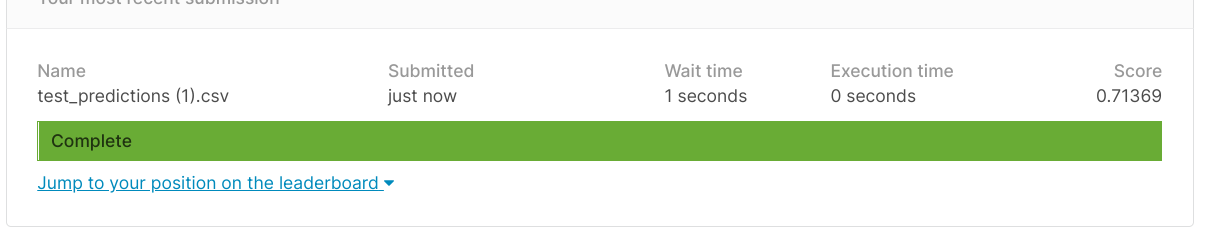

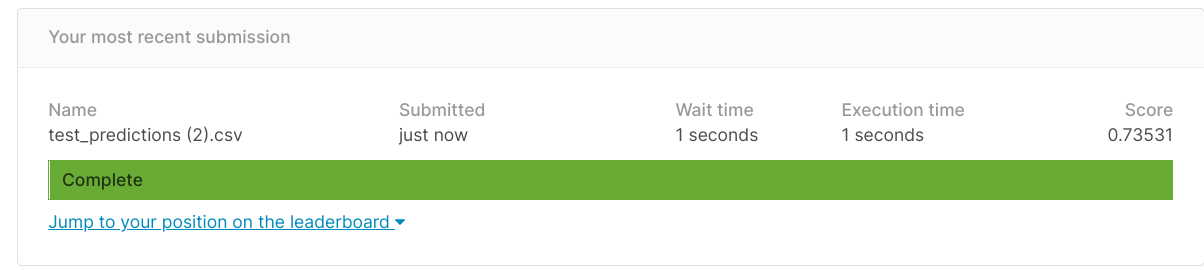

###Embedding Graph

In [ ]:
embeddings = model.layers[0].get_weights()[0]

In [ ]:
def plot_2d_embeddings(embeddings, id_start=1, count=1000):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings, id_start=1, count=1000)

#Convolutional Nerual Network
We wanted to experiment with trying a completely different model from the embedings one.

We weren't quite sure what to expect for this experiment, since we were mostly familiar with CNNs in the context of images, and didn't know how it would do with text. We found that it did a little better than the embedded model.

In [ ]:
from tensorflow.keras import layers, models

def build_convo_model(
                  vocab_size=max_id,
                  sequence_length=pad_length,
                  embedding_dim=64):
  units=288
  drop_rate=.5
  num_layers=1
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length))
  
  model.add(tf.keras.layers.Dropout(
    drop_rate, seed=0))
  for i in range(num_layers):
    model.add(layers.Conv1D(
        units, # "output channels"
        3,
        1,
        padding='valid',
        activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units,        
      activation='relu'))
  model.add(tf.keras.layers.Dropout(drop_rate, seed=0))
  model.add(tf.keras.layers.Dense(
      units=20,                     # output dim (for binary classification)
      activation='softmax'         # sigmoid activation for classification
  ))

  model.compile(loss= 'sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model
  

### Keras-tuner

In [ ]:
from tensorflow.keras import layers, models

def tune_convo_model(hp,
                  vocab_size=max_id,
                  sequence_length=pad_length,
                  embedding_dim=64):
  
  units = hp.Int(name="units", min_value=16, max_value=300, step=16)
  drop_rate = hp.Float(name="drop_rate", min_value=0, max_value=.5, step=.1)
  num_layers = hp.Int(name="layers", min_value=1, max_value=5, step=1)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length))
  
  model.add(tf.keras.layers.Dropout(
    drop_rate, seed=0))
  for i in range(num_layers):
    model.add(layers.Conv1D(
        units, # "output channels"
        3,
        1,
        padding='valid',
        activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units,        
      activation='relu'))
  model.add(tf.keras.layers.Dropout(drop_rate, seed=0))
  model.add(tf.keras.layers.Dense(
      units=20,                     # output dim (for binary classification)
      activation='softmax'         # sigmoid activation for classification
  ))

  model.compile(loss= 'sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model
  

In [ ]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    tune_embeddings_model,
    objective="val_accuracy",
    max_trials=1,
    executions_per_trial=1,
    directory="mnist_kt_test",
    overwrite=True
)

In [ ]:
tuner.search(
    x = X_train_reduced,  # our sparse padded training data
    y = Y_train_sparse,   # corresponding binary labels
    epochs=10,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1            # display some progress output during training
)

Trial 1 Complete [00h 00m 41s]
val_accuracy: 0.7401005625724792

Best val_accuracy So Far: 0.7401005625724792
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = build_convo_model(
                              vocab_size=max_id,
                              sequence_length=pad_length,
                              embedding_dim=64)
history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train_sparse,   # corresponding binary labels
  epochs=10,             # number of passes through the training data
  batch_size=20,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

Epoch 1/10
1432/1432 [==============================] - 24s 17ms/step - loss: 1.5743 - accuracy: 0.5317 - val_loss: 1.1256 - val_accuracy: 0.6600
Epoch 2/10
1432/1432 [==============================] - 22s 15ms/step - loss: 1.0825 - accuracy: 0.6730 - val_loss: 0.9850 - val_accuracy: 0.7052
Epoch 3/10
1432/1432 [==============================] - 22s 16ms/step - loss: 0.9297 - accuracy: 0.7201 - val_loss: 0.9299 - val_accuracy: 0.7322
Epoch 4/10
1432/1432 [==============================] - 22s 16ms/step - loss: 0.8446 - accuracy: 0.7439 - val_loss: 0.8976 - val_accuracy: 0.7344
Epoch 5/10
1432/1432 [==============================] - 22s 16ms/step - loss: 0.7784 - accuracy: 0.7599 - val_loss: 0.8658 - val_accuracy: 0.7524
Epoch 6/10
1432/1432 [==============================] - 22s 16ms/step - loss: 0.7380 - accuracy: 0.7762 - val_loss: 0.8830 - val_accuracy: 0.7524
Epoch 7/10
1432/1432 [==============================] - 22s 16ms/step - loss: 0.6974 - accuracy: 0.7865 - val_loss: 0.8739 -

In [ ]:
model.evaluate(X_val_reduced, Y_val_sparse)

249/249 [==============================] - 1s 5ms/step - loss: 0.9138 - accuracy: 0.7463


[0.9137783050537109, 0.7463230490684509]

In [ ]:
preds = model.predict(X_val_reduced)
preds = np.array([np.argmax(x) for x in preds])

print(f' preds:{preds[:24]}')
print(f'actual:{Y_val_sparse[:24]}')

preds = decode_labels(preds)
print(preds[:6])
print(np.array(Y_val[:6]))

count = 0
for i,cuisine in enumerate(preds):
  if count == 5:
      break
  if reverse_index_label.get(Y_val_sparse[i], '#') != cuisine:
    print(f'Prediction:{cuisine}   Actual:{reverse_index_label.get(Y_val_sparse[i])} \nIngredient list:{decode_ingredients(X_val_reduced[i])}\n\n')
    count += 1

 preds:[13 12 16  1 10  0 10 18 16  0 19  6  0 13 12  0  1  2  0 10 10 10  7 10]
actual:[13 12 16  1 10  0 10 18 16  0 18 12  6 13 16  0  1  2  0 10  7  6 16 10]
['chinese' 'spanish' 'greek' 'indian' 'italian' 'mexican']
['chinese' 'spanish' 'greek' 'indian' 'italian' 'mexican']
Prediction:jamaican   Actual:cajun_creole 
Ingredient list:['sugar', 'bitters', 'rum', 'orange peel', 'water', 'cinnamon sticks', 'golden raisins', 'ice', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>']


Prediction:southern_us   Actual:spanish 
Ingredient list:['sugar', 'unsalted butter', 'milk', 'all purpose flour', 'warm water', 'salt', 'active dry yeast', 'white cornmeal', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>', '<UNUSED>']


Prediction:mexican   Actual:southern_us 
Ingredient list:['mozzarella cheese', 'extra virgin olive

In [ ]:
test_preds = model.predict(X_test_reduced)
test_preds = np.array([np.argmax(x) for x in test_preds])

print(f' preds:{test_preds[:24]}')
test_preds = decode_labels(test_preds)
print(test_preds[:6])

pred = {'id':[test_df['id'][i] for i in range(len(test_df))], 
        'cuisine':[cuisine for cuisine in test_preds]}

pred_df = pd.DataFrame(pred)
pred_df.to_csv('test_cnn_predictions.csv', index=False, header=True, columns=["id","cuisine"])

 preds:[14  6 10 18 10  6 12 13  0 14 10 16  1 10 13  7  6  6  0  6  9  1 17  4]
['british' 'southern_us' 'italian' 'cajun_creole' 'italian' 'southern_us']


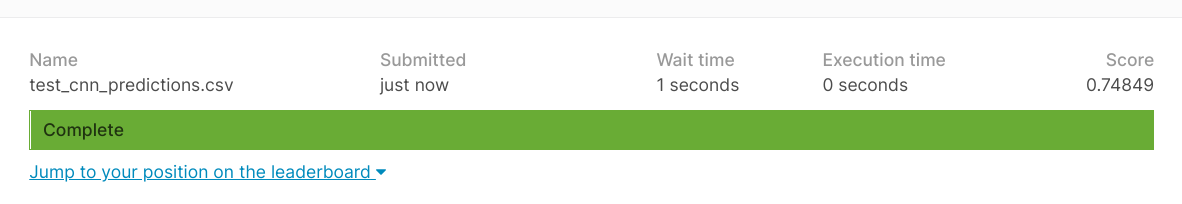

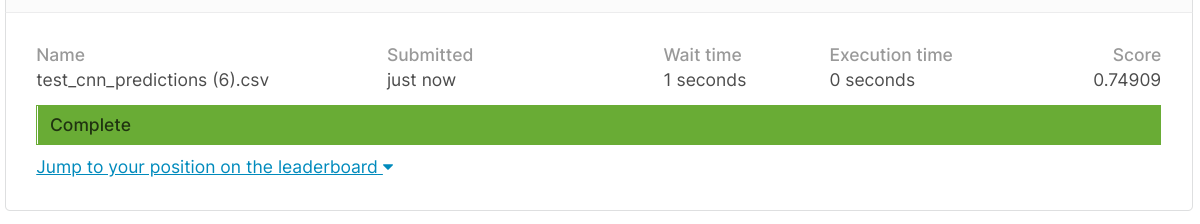

# Error Analysis


---


### Example Errors:

This first example highlights a potential issue that might be caused by our model not differentiating between food and drinks. We think that it's likely the model could become confused when trying to classify a drink that uses ingredients common in another cuisine's food but not necessarily in their drinks.

This could potentially be fixed by having the model first try and classify what type of recipe it is (food, drink, etc), that way it won't be using unrelated information when classifyinng the cuisine. This would of course require access to more training data with food vs drink labels.

**Prediction:** spanish **Actual:** cajun_creole  
**Ingredient list:**['sugar', 'bitters', 'rum', 'orange peel', 'water', 'cinnamon sticks', 'golden raisins', 'ice']

We were surprised that the model incorrectly predicted this recipe, since it seems fairly obvious that it isn't Mexican. However, we also realized that the data has a lot of recipes that appear to be fake, due to having strange and unlikely combinations (ex: we found a recipe featuring both spaghetti and soba noodles), and think that it may be causing some embeddings to have stronger associations than they should.

This would be a fairly difficult to fix with the data as it currently is, but could potentially be adressed by training a model to also recognize fake vs real recipies. We could also try removing recipes over a certain length becuase it seems like many of the longer ones have this issue.

**Prediction:** mexican **Actual:** southern_us  
**Ingredient list:**  ['mozzarella cheese', 'extra virgin olive oil', 'sliced ham', 'flour tortillas', 'cream cheese', 'garlic powder', 'black olives', 'dried oregano', 'sliced salami', 'pimentos', 'provolone cheese']

This example seemed to be the most common issue in both the embedding and CNN models. We think that it would be difficult for even a human to tell which cuisine this salad is from, since many cuisines have a large overlap in the ingredients they commonly use. 

It seems like it would be unresonable to expect the model to be able to differentiate in instances where the correct answer could really go either way.

**Prediction:** italian **Actual:** greek  
**Ingredient list:**['sugar', 'purple onion', 'romaine lettuce', 'extra virgin olive oil', 'olives', 'beefsteak tomatoes', 'cucumber', 'radicchio', 'fresh lemon juice']

# Conclusion

Kaggle's What's Cooking task is a deceptively challenging classification, where a model must predict cuisines based on the ingredients in a recipe. 

This challenge brought up a lot of new considerations: dealing with "real world" data that needed to be cleaned up, deciding the best way to preprocess data for our specific task, and learning how to analyze errors in the model to make adjustments.

We also learned about using keras tuner and found it invaluable for fine tuning our model's hyperparameters, leading to our highest kaggle score (.748).

This task showed us that crafting a machine learning model is a continuous process that always has room for imrovement. Comparing our score to the challenge winners shows we still have a lot to learn, and despite the approaching deadline, are constantly coming up with new experiments that we don't have time to implement.